In [23]:
!pip install split-folders

import os
import cv2
import PIL
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split

path = r"Data1/Hasil/CLAHE"
path_split = r"Data1/datasplit/CLAHE"
kelas = os.listdir(path)
dataset = path
print("Daftar kelas = ",kelas,"\n\nBanyak kelas = ", len(kelas))

Daftar kelas =  ['diving', 'horse_riding', 'tennis_swing'] 

Banyak kelas =  3


In [24]:
import os

dataset="Data1/Hasil/CLAHE"
def daftar_file(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

daftar_file(dataset)

CLAHE/
    diving/
        diving video 1 frame 0.jpg
        diving video 1 frame 10.jpg
        diving video 1 frame 100.jpg
        diving video 1 frame 105.jpg
        diving video 1 frame 110.jpg
        diving video 1 frame 115.jpg
        diving video 1 frame 120.jpg
        diving video 1 frame 125.jpg
        diving video 1 frame 130.jpg
        diving video 1 frame 135.jpg
        diving video 1 frame 140.jpg
        diving video 1 frame 145.jpg
        diving video 1 frame 15.jpg
        diving video 1 frame 150.jpg
        diving video 1 frame 155.jpg
        diving video 1 frame 160.jpg
        diving video 1 frame 165.jpg
        diving video 1 frame 170.jpg
        diving video 1 frame 175.jpg
        diving video 1 frame 180.jpg
        diving video 1 frame 185.jpg
        diving video 1 frame 190.jpg
        diving video 1 frame 195.jpg
        diving video 1 frame 20.jpg
        diving video 1 frame 200.jpg
        diving video 1 frame 205.jpg
        diving video 1 f

In [25]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Tentukan path ke dataset Anda
dataset_path = path

# Tentukan path ke direktori di mana Anda ingin menyimpan dataset terbagi
output_path = path_split

# Tentukan rasio pembagian yang diinginkan (80% pelatihan, 20% pengujian)
train_ratio = 0.8
test_ratio = 0.2

# List semua subdirektori dalam path dataset (diasumsikan setiap subdirektori adalah satu kelas)
class_folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Buat direktori output untuk set pelatihan dan pengujian
train_output_path = os.path.join(output_path, 'train')
test_output_path = os.path.join(output_path, 'test')

os.makedirs(train_output_path, exist_ok=True)
os.makedirs(test_output_path, exist_ok=True)

# Iterasi untuk setiap folder kelas
for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)
    # List semua file dalam folder kelas saat ini
    all_files = [file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))]
    # Bagi file-file tersebut menjadi set pelatihan dan pengujian
    train_files, test_files = train_test_split(all_files, test_size=test_ratio, random_state=42)
    
    # Pindahkan gambar-gambar set pelatihan ke direktori pelatihan
    for file in train_files:
        src_path = os.path.join(class_path, file)
        dst_path = os.path.join(train_output_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    # Pindahkan gambar-gambar set pengujian ke direktori pengujian
    for file in test_files:
        src_path = os.path.join(class_path, file)
        dst_path = os.path.join(test_output_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [26]:
import pandas as pd
import random
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [27]:
# re-size all the images to this
IMAGE_SIZE = (320, 320, 3)
train_path= 'Data1/datasplit/CLAHE/train'
test_path = 'Data1/datasplit/CLAHE/test'

In [28]:
quantity_train = {} 
quantity_test = {}
for folder in os.listdir(train_path):
    quantity_train[folder] = len(os.listdir(train_path+'/'+folder))

for folder in os.listdir(test_path):
    quantity_test[folder] = len(os.listdir(test_path+'/'+folder))


quantity_train = pd.DataFrame(list(quantity_train.items()), index=range(0,len(quantity_train)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_test.items()), index=range(0,len(quantity_test)), columns=['class','count'])

# figure, ax = plt.subplots(1,2,figsize=(20,5))
# sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
# sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Banyak citra di training set:", sum(quantity_train['count'].values))
print("Banyak citra di testing set:",sum(quantity_test['count'].values))
print("Total citra:",sum(quantity_train['count'].values)+sum(quantity_test['count'].values))

# plt.show()

Banyak citra di training set: 15083
Banyak citra di testing set: 3772
Total citra: 18855


In [29]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save ke json 
    hist_json_file = model_name+'-CLAHE_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save ke csv 
    hist_csv_file = model_name+'-CLAHE_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
  try:
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
  except TypeError:
    pass
    
def plot_loss_from_history(history):
  try:
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
  except TypeError:
    pass
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [30]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_path)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_path)):
        image_ids = os.listdir(os.path.join(train_path,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(train_path,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(vgg19_final_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

In [31]:
tf.keras.backend.clear_session()

In [32]:
import os
def savePercobaan():
  try: 
    os.mkdir("Model VGG-19") 
  except OSError as error: 
    print(error)
  saveModel()

In [33]:
def saveModel():
  try: 
    os.mkdir("percobaan"+"/model") 
  except OSError as error: 
    print(error)

In [34]:
#normalisasi
train_datagen = ImageDataGenerator(rescale = 1.0/255., validation_split=0.2, shear_range=0.2,zoom_range=0.2)
train_generator19 = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, shuffle=True, class_mode='categorical', subset='training')

validation_generator19 = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator(rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
test_generator19 = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=1, shuffle=True, class_mode='categorical')

Found 12068 images belonging to 3 classes.
Found 3015 images belonging to 3 classes.
Found 3772 images belonging to 3 classes.


In [35]:
inv_map_classes = {v: k for k, v in validation_generator19.class_indices.items()}
#print(validation_generator19.class_indices)
print(inv_map_classes)

{0: 'diving', 1: 'horse_riding', 2: 'tennis_swing'}


MODEL TRAINING


In [36]:
from keras.layers import BatchNormalization
def vgg19_training(vgg_epoch, learning_rate, batch_size, dropout_rate):
  vgg19_model = VGG19(pooling='max', weights='imagenet', include_top=False, input_shape=(244,244,3), classes=11) #defaultnya AVERAGE POOLING
  for layers in vgg19_model.layers:
              layers.trainable=False

  last_output_vgg19 = vgg19_model.layers[-1].output
  vgg_19 = Flatten()(last_output_vgg19) #awalnya di bawah last output
  vgg_19 = BatchNormalization()(vgg_19)
  vgg_19 = Dense(512, activation = 'relu')(vgg_19)
  vgg_19 = BatchNormalization()(vgg_19)
  vgg_19 = Dropout(dropout_rate)(vgg_19)

  #vgg_19 = Dense(64, activation = 'relu')(vgg_19)
  #vgg_19 = Dropout(dropout_rate)(vgg_19)
  vgg_19 = Dense(3, activation = 'softmax')(vgg_19)
  vgg19_final_model = Model(vgg19_model.input, vgg_19)
  
  opt = Adam(learning_rate=learning_rate)
  vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])
  #vgg19_final_model.summary()

  plot_model(model=vgg19_final_model, show_shapes=True)

  train_generator19.batch_size = batch_size

  vgg19_filepath = '/model/vgg_19_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
  vgg19_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg19_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  vgg19_history = vgg19_final_model.fit(train_generator19, epochs = vgg_epoch, validation_data = validation_generator19,callbacks=[vgg19_checkpoint,early_stopping],verbose=1)

  do_history_stuff (vgg19_history, 'vgg19_model')
  save_vgg19(vgg19_final_model)

  predictionTest(vgg19_final_model)

  return(vgg19_final_model)

In [37]:
def save_vgg19(vgg19_final_model):
  vgg19_final_model.save(('percobaan'+'/vgg19-model'+'.h5'))

In [38]:
def acc_plot(vgg19_history):
  plt.figure(figsize=(10, 8))
  plt.plot(vgg19_history.history['acc'], label='train acc')
  plt.plot(vgg19_history.history['val_acc'], label='val acc')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

In [39]:
def loss_plot(vgg19_history):
  plt.figure(figsize=(10, 8))
  plt.plot(vgg19_history.history['loss'], label='train l/oss')
  plt.plot(vgg19_history.history['val_loss'], label='val loss')
  plt.legend()
  plt.title('Loss')
  plt.show()

In [40]:
def predictionTest(vgg19_final_model):
  true_value = []
  vgg_pred = []
  for folder in os.listdir(test_path):
      test_image_ids = os.listdir(os.path.join(test_path,folder))
      
      for image_id in test_image_ids[:int(len(test_image_ids))]:
          path = os.path.join(test_path,folder,image_id)
          true_value.append(test_generator19.class_indices[folder])
          img = cv2.resize(cv2.imread(path),(244,244))
          img_normalized = img/255
          #vgg
          vgg19_image_prediction = np.argmax(vgg19_final_model.predict(np.array([img_normalized]), verbose = 0)) #verbose biar gak ngeprint
          vgg_pred.append(vgg19_image_prediction)

  print("\n")
  clf_report(true_value, vgg_pred)

In [41]:
arr_accuracy19 = []
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    classes = validation_generator19.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    arr_accuracy19.append(model_accuracy)
    plt.figure(figsize=(11,11))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    plt.savefig("confusion_matrix19_nosegmented.png")
    print(classification_report(true_value, model_pred, target_names = list(classes)))

In [42]:
print(validation_generator19.class_indices.keys())

dict_keys(['diving', 'horse_riding', 'tennis_swing'])


In [43]:
hasilTabel = pd.DataFrame(columns=['Epoch', 'Learning Rate', 'Batch Size', 'Dropout Rate','Accuracy'])
print(hasilTabel)

Empty DataFrame
Columns: [Epoch, Learning Rate, Batch Size, Dropout Rate, Accuracy]
Index: []


RUN KODE

Epoch 1/100
378/378 [==============================] - ETA: 0s - loss: 0.1621 - acc: 0.9472
Epoch 1: val_acc improved from -inf to 0.96086, saving model to /model\vgg_19_-saved-model-01-acc-0.96.hdf5
378/378 [==============================] - 762s 2s/step - loss: 0.1621 - acc: 0.9472 - val_loss: 0.1100 - val_acc: 0.9609
Epoch 2/100


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


378/378 [==============================] - ETA: 0s - loss: 0.0616 - acc: 0.9789
Epoch 2: val_acc improved from 0.96086 to 0.96119, saving model to /model\vgg_19_-saved-model-02-acc-0.96.hdf5
378/378 [==============================] - 762s 2s/step - loss: 0.0616 - acc: 0.9789 - val_loss: 0.1116 - val_acc: 0.9612
Epoch 3/100
378/378 [==============================] - ETA: 0s - loss: 0.0511 - acc: 0.9826
Epoch 3: val_acc did not improve from 0.96119
378/378 [==============================] - 761s 2s/step - loss: 0.0511 - acc: 0.9826 - val_loss: 0.1247 - val_acc: 0.9579
Epoch 4/100
378/378 [==============================] - ETA: 0s - loss: 0.0451 - acc: 0.9838
Epoch 4: val_acc did not improve from 0.96119
378/378 [==============================] - 763s 2s/step - loss: 0.0451 - acc: 0.9838 - val_loss: 0.2657 - val_acc: 0.9151
Epoch 5/100
378/378 [==============================] - ETA: 0s - loss: 0.0376 - acc: 0.9854
Epoch 5: val_acc did not improve from 0.96119
378/378 [====================

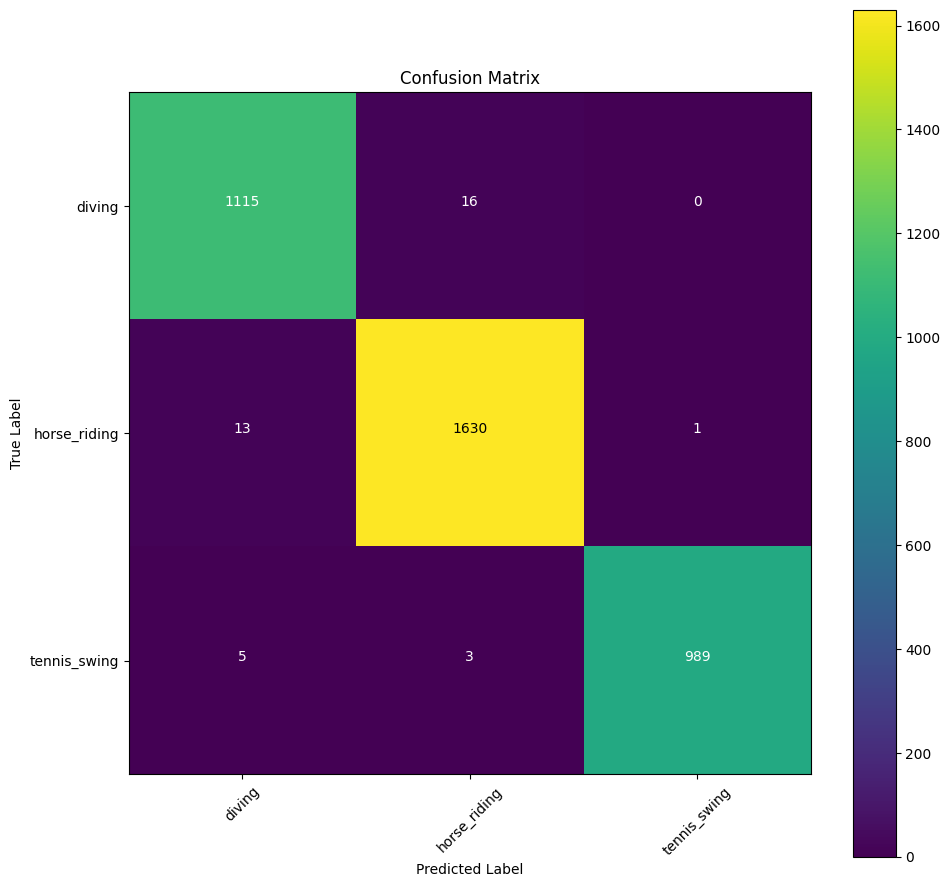

In [44]:
# Define the hyperparameters
vgg_epoch = 100
learning_rate = 0.001
batch_size = 32
dropout_rate = 0.5

# Call the function with the defined hyperparameters
vgg19_training(vgg_epoch, learning_rate, batch_size, dropout_rate)


import warnings

# Menonaktifkan semua pesan peringatan
warnings.filterwarnings('ignore')

In [45]:
print(arr_accuracy19)

[0.9899257688229056]
